Read state-by-state presidential poll data from [fivethirtyeight.com](http://fivethirtyeight.com) [database](https://github.com/fivethirtyeight/data/tree/master/polls). 

In [1]:
import numpy as np
from matplotlib import pylab as plt
import pandas as pd 
import pandas # pandas is a module for reading cav formatted data and more
from datetime import datetime as dt
from datetime import date

In [2]:
url = './data/president_polls.csv'
pad = pandas.read_csv(url)

In [3]:
def poll_weight(
    numeric_grade,
    is_projection,
    start_date,
    end_date,
    pollscore,
    sample_size,
    reference_today_date,
    time_penalty=14,
    harris_and_before_dropout=False,
    pollster_name: str = None,
    exclude_pollsters: list[str] | None = None,  # To answer a reddit question, not actually used
):
    """Given factors about a poll return some weighting. This is somewhat
    arbitrary and could be adjusted.

    Args:
        numeric_grade: The 538 rating of the pollster. Rated out of 3.0.
        is_projection: If the poll is a projection (not currently used)
        start_date: The start date of the poll
        end_date: The end date of the poll
        pollscore: The 538 pollster score. Lower values are better. Like the
            numberic grade, but just measures empirical track record, not
            factors like transparency.
        sample_size: The number of people polled
        reference_today_date: The date to use when weighting old polls
        time_penalty: Approximately the days half life
        harris_and_before_dropout: If the poll is for Harris and before the
            dropout day
        pollster_name: The name of the pollster
        exclude_pollsters: A list of pollsters to exclude (matches any substring)
            Not actually used in the function, but is a parameter to make it
            easier to answer a reddit question.
    """
    # If NaN then numeric_grade 1.5
    if pd.isna(numeric_grade):
        grade_clipped = 1.5
    else:
        grade_clipped = max(0.0, min(2.7, numeric_grade))
    score = grade_clipped**1.5 / 2.7**1.5
    if is_projection:
        score = (score**2) * 0.5
    # Pollscore which is some value considering only performance (ignoring transparency)
    # Lower values are better
    if pd.isna(pollscore):
        pollscore = 0.0
    score *= np.interp(pollscore, [-1.1, 0.5], [1.0, 0.6])
    # Some sample size consideration
    if pd.isna(sample_size):
        if numeric_grade > 2.0:
            sample_size = 500
        else:
            sample_size = 300
    score *= np.interp(sample_size, [200, 900], [0.7, 1.0])
    if pd.isna(start_date) or pd.isna(end_date):
        return 0
    # Time decay
    end_days = (reference_today_date - end_date).days
    if end_days < 0:
        return 0  # in the future
    start_days = (reference_today_date - start_date).days
    # Find a middle date (putting more weight on end date since I think some
    # pollsters will start out smaller and scale up(??))
    days = (end_days * 2 + start_days * 1) / 3
    days -= 1.5  # Prep time
    days = max(0, days)
    # Subtract a prep day
    time_decay = 0.5 ** (days / time_penalty)
    if harris_and_before_dropout:
        score *= 0.25
    score *= time_decay
    # Especially punish low quality
    #score = score ** 1 + days.days / time_decay

    if exclude_pollsters and pollster_name: # for reddit question
        for pollster in exclude_pollsters:
            if pollster_name.lower() in pollster.lower():
                return 0.0

    if score < 0:
        return 0.0
    return score

In [4]:
def add_poll_weights(df, reference_date):
    # Convert date columns to datetime
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    # Set reference_today_date to the latest end_date in the dataset
    reference_today_date = pd.Timestamp(reference_date)#pd.Timestamp(date.today())
    
    # Apply the poll_weight function to each row
    df['weight'] = df.apply(lambda row: poll_weight(
        row['numeric_grade'],
        True,  # Assuming is_projection is always False for this dataset
        row['start_date'],
        row['end_date'],
        row['pollscore'],
        row['sample_size'],
        reference_today_date,
        pollster_name=row['pollster']
    ), axis=1)
    
    return df


In [5]:
def combine_districts(state):
    # Dictionary to map districts to states
    district_to_state = {
        'Maine CD-1': 'Maine',
        'Maine CD-2': 'Maine',
        'Nebraska CD-2': 'Nebraska'
    }
    
    # Return the mapped state if it's a district, otherwise return the original state
    return district_to_state.get(state, state)

In [15]:
# Convert to datetime format, handling errors and dropping problematic rows
try:
    pad['startdate'] = pd.to_datetime(pad['start_date'], format='%m/%d/%y')
except ValueError:
    # If parsing fails, mark those rows as problematic
    pad['startdate'] = pd.NaT
    
try:
    pad['enddate'] = pd.to_datetime(pad['end_date'], format='%m/%d/%y')
except ValueError:
    # If parsing fails, mark those rows as problematic
    pad['enddate'] = pd.NaT

    
pad = pad.dropna(subset=['startdate', 'enddate','state'])
# convert data frame to Python dictionary with keys containing names of columns in the data frame
# and each key containing a list of strings or float values
pad = pad.dropna(subset=['state','start_date','end_date'])
pad = add_poll_weights(pad,'10-06-2024')
pad = pad[pad['weight'] >0]
pad['state'] = pad['state'].apply(combine_districts)

pad = pad[pad['party'].isin(['DEM','REP'])]
ppl = pad.to_dict(orient = 'list') 
ppl.keys()
# now ppl is a dictionary containing poll data

dict_keys(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id', 'pollster_rating_name', 'numeric_grade', 'pollscore', 'methodology', 'transparency_score', 'state', 'start_date', 'end_date', 'sponsor_candidate_id', 'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id', 'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id', 'sample_size', 'population', 'subpopulation', 'population_full', 'tracking', 'created_at', 'notes', 'url', 'url_article', 'url_topline', 'url_crosstab', 'source', 'internal', 'partisan', 'race_id', 'cycle', 'office_type', 'seat_number', 'seat_name', 'election_date', 'stage', 'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round', 'party', 'answer', 'candidate_id', 'candidate_name', 'pct', 'startdate', 'enddate', 'weight'])

In [17]:
pad['state'].unique()

array(['Illinois', 'New Hampshire', 'New Jersey', 'Nebraska', 'Michigan',
       'Arizona', 'Nevada', 'North Carolina', 'Georgia', 'Wisconsin',
       'North Dakota', 'New York', 'Ohio', 'Indiana', 'Pennsylvania',
       'Alaska', 'South Carolina', 'Iowa', 'Texas', 'Florida',
       'Minnesota', 'Virginia', 'California', 'Maryland', 'Delaware',
       'Rhode Island', 'Montana', 'Massachusetts', 'New Mexico',
       'Connecticut', 'Colorado', 'Maine', 'Missouri', 'Arkansas',
       'Washington', 'Oklahoma', 'Tennessee', 'West Virginia', 'Vermont',
       'Utah', 'Oregon', 'South Dakota', 'Louisiana', 'Hawaii', 'Alabama',
       'Idaho', 'Kansas', 'Kentucky', 'Mississippi', 'Wyoming'],
      dtype=object)

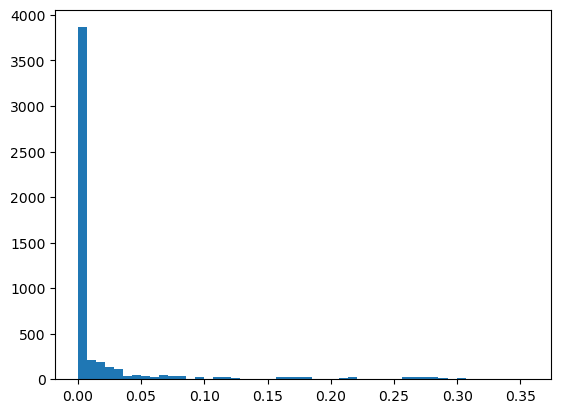

In [20]:
plt.hist(pad['weight'],bins=50);

In [22]:
pad['weight'].sum()

110.79003561259816

Read the list of states and the number of electoral votes each state has. 

In [24]:
states_electoral = pandas.read_csv('./data/states_electoral.csv')
states_electoral

,State,Name,Electors,Population
0,AK,Alaska,3,710000
1,AL,Alabama,9,4780000
2,AR,Arkansas,6,2916000
3,AZ,Arizona,11,6392000
4,CA,California,55,37254000
5,CO,Colorado,9,5029000
6,CT,Connecticut,7,3574000
7,DC,District of Columbia,3,602000
8,DE,Delaware,3,898000
9,FL,Florida,29,18801000


In [26]:
states_abrv = np.array(states_electoral['State'])
states      = np.array(states_electoral['Name'])
electors    = np.array(states_electoral['Electors'])
nstates     = states.size
state_pop = np.array(states_electoral['Population'])

Sort states by alphabetical order using their names in states. 

So now we can organize a loop over states and carry out some number of Monte Carlo simulations of election outcomes based on the poll results by drawing outcomes from the assumed distribution around the mean poll percentage for each candidate, comparing the drawn percentages and deciding who wins the state. In the unlikely event of a draw you can either give all the electoral votes to one candidate or generate a uniformly distributed random number in $[0,1]$ interval and give to Biden if the number is less than 0.5 and to Trump if it's larger than 0.5. 

### Model implementation and simulation results

This is an example of how solution can be approached. I do not include exploration of the poll result distributions because there are many examples of how this distribution can be constructed in the class notebooks that I distributed. 

Results of this exploration can be summarized as follows: 

* Distributions for different states are diverse, and often are quite different for the two candidates in the same state. 


* Distributions tend to peak around some value, so uniform distribution is not a particularly good description (see below, however, for how it could be used as a conservative estimate). 


* Some distributions are described by the Gaussian pdf and so it may be one of the reasonable choices for the model distribution. 


* Many distributions, however, have tails that are not consistent with the Gaussian and so t-distribution with a small number of degrees of freedom may be a better description overall. 


* Distributions do not look uniform, but given that often there are strong tails the uniform pdf could be used as a "conservative" model to give the largest spread of the poll results. 

Overall, I chose to use $t$-distribution as a compromise model. Given that polls are strongly correlated, I've made a conservative assumption that the standard deviation of the poll results is the width of my model distribution. 

As mentioned this week when we have samples from a parent distribution that we don't know, we can use bootstrap method to generate many model samples. This was not expected from you, but in my model implementation below I do include modelling using bootstrap as one of the options (it could be turned on by setting <tt>bootstrap=True</tt> on input, although this option does not work if <tt>correlations=True</tt>. 

In [28]:
def election_stats(model_name, model_results):
    """
    Helper function to output basic statistics about results of a model
    
    Parameters: 
    -----------
    model_name: string containing name of the model
    
    model_results: a list of arrays output by simulate_elections function
    """
    biden_electoral_votes, trump_electoral_votes = model_results[0], model_results[1]
    biden_vote_dist, trump_vote_dist = model_results[2], model_results[3]
    nsims = np.shape(biden_electoral_votes)[0]
    
    print('='*15+'Results of election simulations in the ', model_name, '===')

    trump_wins   = (trump_electoral_votes > biden_electoral_votes) 
    biden_wins = (trump_electoral_votes < biden_electoral_votes) 
    draws = (trump_electoral_votes == biden_electoral_votes) 
    fdraws = len(biden_electoral_votes[draws]) / nsims
    fbiden_wins = len(biden_electoral_votes[biden_wins]) / nsims
    ftrump_wins   = len(trump_electoral_votes[trump_wins]) / nsims

    print("Harris wins in %.4f per cent of elections"%(fbiden_wins*100.))
    print("        average and median Nelectoral = %.2f and %.2f; in 95 percent range = [%.2f  %.2f]"%(
        np.mean(biden_electoral_votes), np.median(biden_electoral_votes), 
        np.percentile(biden_electoral_votes,2.5), np.percentile(biden_electoral_votes,97.5)))
    print("Trump   wins in %.4f per cent of elections"%(ftrump_wins*100.))
    print("        average and median Nelectoral = %.2f and %.2f; in 95 percent range = [%.2f  %.2f]"%(
        np.mean(trump_electoral_votes), np.median(trump_electoral_votes), 
        np.percentile(trump_electoral_votes,2.5), np.percentile(trump_electoral_votes,97.5)))

    print(" %.4f per cent of elections end up in electoral college draw"%(fdraws*100.))


In [30]:
def state_results(model_name, model_results, states, states_to_print=None):
    """
    Helper function to output basic statistics about results in specific states
    
    Parameters: 
    -----------
    model_name: string containing name of the model
    
    model_results: a list of arrays output by simulate_elections function
    
    states: array of strings of state names
    
    states_to_print: a list of state names that will be printed. If None, all states will be printed
    """
    
    biden_electoral_votes, trump_electoral_votes = model_results[0], model_results[1]
    biden_vote_dist, trump_vote_dist = model_results[2], model_results[3]
    nsims = np.shape(biden_electoral_votes)[0]
    
    if states_to_print is None: 
        states_to_print = states
        
    nc = np.zeros(51); colors = np.zeros((51,4))
    print('='*10+' State-by-state vote predictions for {:s} '.format(model_name)+'='*10)
    print('               State   Haris win prob.  Trump win prob. ')
    for i, ncd in enumerate(nc): 
        if states[i] in states_to_print: 
            biden_wins = (biden_vote_dist[i,:] > trump_vote_dist[i,:]) 
            trump_wins   = (trump_vote_dist[i,:] > biden_vote_dist[i,:])
            vote_ratio_trump = len(trump_vote_dist[i,trump_wins]) / nsims
            vote_ratio_biden = len(biden_vote_dist[i,biden_wins]) / nsims
            print("%20s        %.3f           %.3f"%(states[i], vote_ratio_biden, vote_ratio_trump))


In [32]:
def plot_electoral_vote_distribution(model_name, model_results, 
                                     nbins=40, savefig=None):
    """
    plot histogram of the electoral vote distribution based on model elections
    Parameters:  
        biden_electoral_votes, 
        trump_electoral_votes = total counts of electoral votes for Biden and Trump in model elections
        nbins = number of bins to use 
    """
    
    biden_electoral_votes, trump_electoral_votes, = model_results[0], model_results[1], 
    nsims = np.shape(biden_electoral_votes)[0]

    _, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.set_title(model_name)
    ax.set_xlabel(r'$N_{\rm electoral\ votes}$')
    ax.set_ylabel(r'fraction of model elections')
    ax.hist(biden_electoral_votes, color='b', histtype='stepfilled', alpha=0.7, bins=nbins, 
            label=r'Harris', density = 'True')
    ax.hist(trump_electoral_votes,color='r', histtype='stepfilled', alpha=0.7, bins=nbins, 
            label=r'Trump', density = 'True')
    ax.legend(loc='best', frameon=False, fontsize=15)


    if savefig != None:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

In [34]:
def plot_nelectoral_vs_popular_vote(model_name, model_results, states, electors, state_pop, savefig=None):
    """
    plots of the expected Electoral College votes vs. the fraction of popular vote 
    received for all of the elections
    """
    
    biden_electoral_votes, trump_electoral_votes = model_results[0], model_results[1]
    biden_vote_dist, trump_vote_dist = model_results[2], model_results[3]   
    nsims = np.shape(biden_electoral_votes)[0]
    biden_pop_vote, trump_pop_vote, = np.zeros(nsims), np.zeros(nsims)
    
    # compute the popular vote fractions
    total_pop   = np.sum(state_pop)
    nstates     = states.size
    fstate_pop = state_pop / total_pop
    
    for i, state in enumerate(states):
        biden_pop_vote[:] += biden_vote_dist[i,:] * state_pop[i] * 0.5 / 100
        trump_pop_vote[:] += trump_vote_dist[i,:] * state_pop[i] * 0.5 / 100
    
    _, ax = plt.subplots(1, 1, figsize=(6,6))
    plt.rc('font', size=15)
    ax.set_xlim(50., 100.)
    ax.set_xlabel('N_popular (millions)', fontsize=12)
    ax.set_ylabel('N_electoral', fontsize=12)
    ax.scatter(biden_pop_vote*1.e-6, biden_electoral_votes, marker='.', s=5.0, edgecolor='none', alpha=0.5, c='b')
    ax.scatter(trump_pop_vote*1.e-6, trump_electoral_votes, marker='.', s=5.0, edgecolor='none', alpha=0.5, c='r')
    x = np.arange(0., 100, 0.1); y = 270. * np.ones_like(x)
    ax.plot(x, y, '--', c='m')
    plt.title(model_name)

## TODO

1. Implement weights
2. if there are no polls, 50/50 chances. If it is DC, give it to DEM.

In [97]:
from numpy.random import standard_t as tdist

def std_weighted(values, average, weights):
    # implementing unbiased weighted std formula 
    # http://mathoverflow.net/questions/11803/unbiased-estimate-of-the-variance-of-a-weighted-mean
    average = np.sum(weights*values)
    variance = np.sum(weights * (values-average)**2) / (1. - np.sum(weights**2))
    return np.sqrt(variance)

def simulate_elections(ppd, states, electors, bias = False, correlations = False, 
                       date_range = None, poll_type = 'pct', min_weight = 0.01, nsims = 1000, 
                       poll_permute = False, **kwargs):
    """
    Simulate election outcomes
    
    Parameters:
    -----------
        ppd:          dictionary with the 538 poll data
        states:       a list of strings of state names
        electors:     a list of integers = the number of electors of each state
        bias:         boolean, flag to apply bias correction
        correlations: boolean, flag to use covariance matrix to impose correlations 
                      on simulated values in different states
        poll_permute: boolean, flag indicating whether to use bootstrap of poll results
                        for Monte Carlo model realizations
        kwargs:       dictionary of additional keyword arguments that are used to pass data such as 
                      covariance matrices
        
    """
    
    nstates = len(states)
    
    # initialize arrays 
    ave_biden, std_biden, n_biden = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=int); 
    ave_trump, std_trump, n_trump = np.zeros(nstates), np.zeros(nstates), np.zeros(nstates, dtype=int); 
    
    biden_vote_dist = np.zeros((nstates,nsims))
    trump_vote_dist = np.zeros((nstates,nsims))
    
    biden_electoral_votes = np.zeros(nsims)
    trump_electoral_votes = np.zeros(nsims)    
    
    ndraws = 0 
    
    if bias: # extract bias vectors
        dem_bias = kwargs['dem_bias']
        rep_bias = kwargs['rep_bias']
    
    if correlations: # extract covariance matrices
        cov_dem = kwargs["cov_dem"]
        cov_rep = kwargs["cov_rep"]
    
    # main loop over states
    for i, state in enumerate(states): 

        # array of the polls for which element is for a given state
        stind = (np.array(ppd['state']) == state)

        #the following lines convert list for a key to np array and select elements for each wyind contains True
        name      = np.array(ppd['candidate_name'])[stind] 
        polls     = np.array(ppd[poll_type])[stind]
        wpoll     = np.array(ppd['weight'])[stind]
        startdate = np.array(ppd['startdate'])[stind]
        enddate   = np.array(ppd['enddate'])[stind]
        party     = np.array(ppd['party'])[stind]

        # convert dates into format that would be easy to use for selection
        #startdates = []#np.empty_like(startdate)
        #enddates = []#np.empty_like(enddate)
        #for j in range(startdate.size): 
            
        #    startdates.append(dt.strptime(startdate[j], "%m/%d/%y"))
        #    enddates.append(dt.strptime(enddate[j], "%m/%d/%y"))
            #print(j,startdates[j], enddates[j])

        startdates = pd.Series(startdate)
        enddates   = pd.Series(enddate)
        #startdates = np.array(startdates)
        #enddates   = np.array(enddates)

        # need to change to Harris. and get new data. 
        #indb = ((party == 'DEM') & (wpoll >= min_weight) &  
        #                       (startdates > pd.to_datetime(date_range[0])) & (enddates <= pd.to_datetime(date_range[1])))
        #indt = ((party == 'REP') & (wpoll >= min_weight) &  
        #                       (startdates > pd.to_datetime(date_range[0])) & (enddates <= pd.to_datetime(date_range[1])))
                # need to change to Harris. and get new data. 
        indb = ((name == 'Kamala Harris') & (wpoll >= min_weight) &  
                               (startdates > pd.to_datetime(date_range[0])) & (enddates <= pd.to_datetime(date_range[1])))
        indt = ((party == 'Donald Trump') & (wpoll >= min_weight) &  
                               (startdates > pd.to_datetime(date_range[0])) & (enddates <= pd.to_datetime(date_range[1])))
        
        
        
        # Current data have no DC polls
        if len(indb) == 0 or len(indt) == 0:
            if state == 'District of Columbia':            
                ave_biden[i] = 1.0  # 100% for Biden
                ave_trump[i] = 0.0  # 0% for Trump
                std_biden[i] = 0.0  # No uncertainty
                std_trump[i] = 0.0  # No uncertainty
                biden_votes = np.ones(nsims)  # All simulations give Biden 100%
                trump_votes = np.zeros(nsims)  # All simulations give Trump 0%
                biden_electoral_votes += electors[i]  # Biden always wins DC
                continue  # Skip to the next state
            continue

    
        
        poll_wb = wpoll[indb] 
        poll_wb /= np.sum(poll_wb)
        poll_wt = wpoll[indt] 
        poll_wt /= np.sum(poll_wt)
        biden_polls   = polls[indb]
        trump_polls   = polls[indt]
        n_biden[i] = biden_polls.size 
        n_trump[i] = trump_polls.size 
    
        if np.sum(poll_wb) > 0 and np.sum(poll_wt) > 0:
            # compute weighted averages and st devs for polls in the selected date range
            ave_biden[i] = np.average(biden_polls, weights=poll_wb)
            ave_trump[i] = np.average(trump_polls, weights=poll_wt)

            std_biden[i] = std_weighted(biden_polls, ave_biden[i], poll_wb)
            std_trump[i] = std_weighted(trump_polls, ave_trump[i], poll_wt)
        else:
            
            print('------------')
            print(f"Warning: No valid polls with non-zero weights for {state}")
            print('b=',poll_wb)
            print('t=',poll_wt)
            print('------------')
            # Option 2: Assign default values
            ave_biden[i] = 0.5  # Default to 50% for both candidates
            ave_trump[i] = 0.5
            std_biden[i] = 0.05  # Default standard deviation of 5%
            std_trump[i] = 0.05
            
        if bias: # if this option, apply bias to the averages
            ave_biden[i] += dem_bias[i]
            ave_trump[i] += rep_bias[i]
                
        if poll_permute: # use bootstrap for model realization
            nx = biden_polls.size
            ibs = np.random.choice(nx, size = nsims)
            biden_votes = biden_polls[ibs] 
            trump_votes = trump_polls[ibs] 
        elif correlations: # if correlations are to be imposed only produce random numbers
            biden_votes = tdist(n_biden[i]-1, size = nsims)
            trump_votes = tdist(n_trump[i]-1, size = nsims)
        else: # realization for the fiducial model
            biden_votes = ave_biden[i] + std_biden[i] * tdist(max(1,n_biden[i]-1), size = nsims)
            trump_votes = ave_trump[i] + std_trump[i] * tdist(max(1,n_trump[i]-1), size = nsims)
    
        # now we can process simulations. using numpy filtering ops
        # allows us to avoid any loops over simulations here
        if correlations: 
            biden_vote_dist[i,:] = biden_votes
            trump_vote_dist[i,:] = trump_votes
        else:                
            draws = (trump_votes == biden_votes)
            biden_wins = (biden_votes[:] > trump_votes[:])  
            trump_wins = (trump_votes[:] > biden_votes[:])

            biden_electoral_votes[biden_wins] += electors[i]
            # I asked you to assign draws with 50% probability but here they are all assigned to Trump
            # to see how this boosts his changes, the chance of a draw here is negligible however
            trump_electoral_votes[draws]      += electors[i] # assume all draws go to Trump
            
            trump_electoral_votes[trump_wins] += electors[i]
            ndraws += len(trump_electoral_votes[draws])
            biden_vote_dist[i,:] = biden_votes
            trump_vote_dist[i,:] = trump_votes
        
    # now handle case where correlations are imposed 
    if correlations: 
        # Cholesky decomposition of covariance matrices
        l_dem = np.linalg.cholesky(cov_dem)
        l_rep = np.linalg.cholesky(cov_rep)
        for j in range(nsims):
            # generate correlated random numbers 
            biden_vote_dist[:,j] = ave_biden + np.dot(l_dem, biden_vote_dist[:,j]) 
            trump_vote_dist[:,j] = ave_trump + np.dot(l_rep, trump_vote_dist[:,j]) 
        # analyze simulations for different states
        for j in range(nstates):
            biden_votes, trump_votes = biden_vote_dist[j,:], trump_vote_dist[j,:]
            draws = (trump_votes == biden_votes)
        
            biden_electoral_votes[(biden_votes[:]>trump_votes[:])] += electors[j]
            trump_electoral_votes[draws] += electors[j] # assume all draws go to Trump
            trump_electoral_votes[(trump_votes[:]>biden_votes[:])] += electors[j]        

    return biden_electoral_votes, trump_electoral_votes, biden_vote_dist, trump_vote_dist, ave_biden, ave_trump
    

### The simplest model

Let's start with the simplest model

In [100]:
ppl.keys()

dict_keys(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id', 'pollster_rating_name', 'numeric_grade', 'pollscore', 'methodology', 'transparency_score', 'state', 'start_date', 'end_date', 'sponsor_candidate_id', 'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id', 'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id', 'sample_size', 'population', 'subpopulation', 'population_full', 'tracking', 'created_at', 'notes', 'url', 'url_article', 'url_topline', 'url_crosstab', 'source', 'internal', 'partisan', 'race_id', 'cycle', 'office_type', 'seat_number', 'seat_name', 'election_date', 'stage', 'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round', 'party', 'answer', 'candidate_id', 'candidate_name', 'pct', 'startdate', 'enddate', 'weight'])

In [112]:
pad[pad['state'] == 'Alaska']

,poll_id,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,pollster_rating_name,numeric_grade,pollscore,...,ranked_choice_reallocated,ranked_choice_round,party,answer,candidate_id,candidate_name,pct,startdate,enddate,weight
75,88439,1334,Alaska Survey Research,NaN,NaN,Alaska Survey Research,155,Alaska Survey Research,1.9,-0.1,...,False,NaN,DEM,Harris,16661,Kamala Harris,43.0,2024-09-27,2024-09-29,9.629511e-02
76,88439,1334,Alaska Survey Research,NaN,NaN,Alaska Survey Research,155,Alaska Survey Research,1.9,-0.1,...,False,NaN,REP,Trump,16651,Donald Trump,52.0,2024-09-27,2024-09-29,9.629511e-02
1297,88165,1334,Alaska Survey Research,NaN,NaN,Alaska Survey Research,155,Alaska Survey Research,1.9,-0.1,...,False,NaN,DEM,Harris,16661,Kamala Harris,42.0,2024-09-11,2024-09-12,4.219249e-02
1298,88165,1334,Alaska Survey Research,NaN,NaN,Alaska Survey Research,155,Alaska Survey Research,1.9,-0.1,...,False,NaN,REP,Trump,16651,Donald Trump,47.0,2024-09-11,2024-09-12,4.219249e-02
1667,88037,1347,Cygnal,452,NRCC,Cygnal,67,Cygnal,2.1,-1.1,...,False,NaN,DEM,Harris,16661,Kamala Harris,43.1,2024-08-30,2024-09-01,3.405216e-02
1668,88037,1347,Cygnal,452,NRCC,Cygnal,67,Cygnal,2.1,-1.1,...,False,NaN,REP,Trump,16651,Donald Trump,53.0,2024-08-30,2024-09-01,3.405216e-02
7034,86839,1697,Bullfinch,2072,Independent Center,The Bullfinch Group,692,The Bullfinch Group,NaN,NaN,...,False,NaN,DEM,Biden,19368,Joe Biden,36.0,2024-04-16,2024-04-23,1.159871e-05
7035,86839,1697,Bullfinch,2072,Independent Center,The Bullfinch Group,692,The Bullfinch Group,NaN,NaN,...,False,NaN,REP,Trump,16651,Donald Trump,55.0,2024-04-16,2024-04-23,1.159871e-05
7036,86839,1697,Bullfinch,2072,Independent Center,The Bullfinch Group,692,The Bullfinch Group,NaN,NaN,...,False,NaN,DEM,Biden,19368,Joe Biden,26.0,2024-04-16,2024-04-23,1.159871e-05
7037,86839,1697,Bullfinch,2072,Independent Center,The Bullfinch Group,692,The Bullfinch Group,NaN,NaN,...,False,NaN,REP,Trump,16651,Donald Trump,49.0,2024-04-16,2024-04-23,1.159871e-05


In [114]:
date_range = ['2024-04-01', '2024-10-06']
nsims = 100000
poll_type = 'pct'
#ppl['startdate'] = ppl['start_date']
#ppl['enddate'] = ppl['end_date']

simplest_model_results = simulate_elections(ppl, states=states, electors=electors, date_range=date_range, 
                                            poll_type=poll_type, min_weight = 0.001, nsims = nsims)

------------
b= [0.55810386 0.24453779 0.19735835]
t= []
------------
------------
b= []
t= []
------------
------------
b= [1.]
t= []
------------
------------
b= [0.02240838 0.0130213  0.06521397 0.04867505 0.04867505 0.01442968
 0.01442968 0.01442968 0.01442968 0.00508053 0.00508053 0.05091315
 0.04794564 0.05091315 0.04794564 0.04757581 0.04757581 0.04045732
 0.04036862 0.04036862 0.04036862 0.04036862 0.0071273  0.03793038
 0.00955232 0.00367136 0.00367136 0.00367136 0.00367136 0.00030879
 0.02021972 0.00429723 0.00591859 0.00502116 0.00502116 0.00502116
 0.00502116 0.00072379 0.0049909  0.01078573 0.01254798 0.00211867
 0.0034039  0.0034039  0.0033598  0.0033598  0.01231502 0.01231502
 0.00087829 0.00087829 0.00427802 0.00427802 0.00076077 0.00076077
 0.00061754 0.00076077 0.00114825 0.00604806 0.00604806 0.00604806
 0.00604806 0.0003907  0.00029407 0.00029407 0.00081383 0.00044154
 0.00062606 0.00034971 0.00034971 0.0002971  0.0003114  0.0007704
 0.0007704  0.00037688 0.00226294

In [116]:
model_name = 'model 1 (simplest model)'
election_stats(model_name, simplest_model_results)

===============Results of election simulations in the  model 1 (simplest model) ===
Harris wins in 50.6570 per cent of elections
        average and median Nelectoral = 270.41 and 270.00; in 95 percent range = [172.00  368.00]
Trump   wins in 48.5290 per cent of elections
        average and median Nelectoral = 267.59 and 268.00; in 95 percent range = [170.00  366.00]
 0.8140 per cent of elections end up in electoral college draw


In [118]:
contested_states = ['Nevada', 'Texas', 'Iowa', 'Michigan', 'Wisconsin', 
                    'Ohio', 'Georgia', 'Florida', 'North Carolina', 'Arizona', 'Pennsylvania']

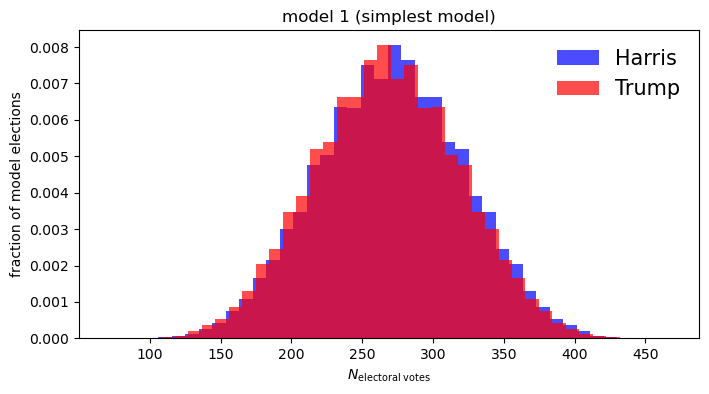

========== State-by-state vote predictions for model 1 (simplest model) ==========
               State   Haris win prob.  Trump win prob. 
             Arizona        0.500           0.500
             Florida        0.497           0.503
             Georgia        0.501           0.499
                Iowa        0.498           0.502
            Michigan        0.497           0.503
      North Carolina        0.502           0.498
              Nevada        0.502           0.498
                Ohio        0.498           0.502
        Pennsylvania        0.499           0.501
               Texas        0.498           0.502
           Wisconsin        0.498           0.502


In [120]:
plot_electoral_vote_distribution(model_name, simplest_model_results)
state_results(model_name, simplest_model_results, states, states_to_print=contested_states)

We see that the model predicts very low probability of Trump winning or a draw in the electoral college, which we now know seems inconsistent with how competitive this election turned out to be. 

At the same time, probabilities for individual states make sense both based on what we saw in the polls and what actually happened in the election in these states. The reason overall Trump's probability to win is small is because his probability to win in many of the states that he must win to win the election is quite small. Given that simulations in different states are independent in this case, probabilities to win in different states are multiplied
to get the total win probability, which turns out to be quite small for Trump. 

There are some states where model predictions are not quite right. Probability of Trump winning in Florida, Michigan, Nevada, Pennsylvania, Texas, and Wisconsin seem to be significantly underestimated. Let's keep this is in mind, as this is the reason why the actual election was much more competitive than this model predicted. 

I did explore using different distribution, including using bootstrap samples of the polls as the samples in simulations (this option can be used by setting input parameter <tt>permute_polls</tt> to True.) None of the assumptions about distributions made a significant difference on the outcome. 

Finally, the plot below shows the number of popular votes vs the number of electoral votes in different simulations in this model. Here is is assumed that there is a uniform turnout of 50% of the population in each state. So this is an approximation to what would actually happen, but not a bad one. 

The dashed line shows the number of electoral votes needed for winning the election. The plot illustrates that a large range of electoral votes is possible for a fairly narrow range of popular vote counts. This is why a candidate who receives fewer popular votes can still have a good probability of winning an election. 

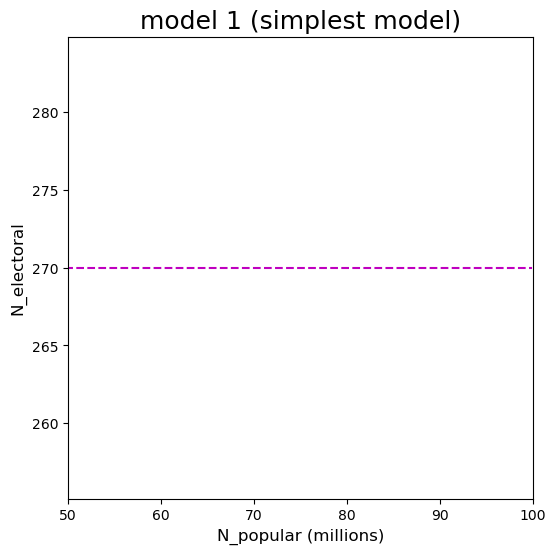

In [73]:
plot_nelectoral_vs_popular_vote(model_name, simplest_model_results, states, electors, state_pop)

### Model with bias

Given that we know that historically results of elections are often quite different from poll predictions, we can try to use historical data on such bias and try to correct results of the model for such bias. 

This is done in the model below. The first cell reads in historical data from 3 previous election and computes the average difference between results and polls for the three year in each state. 

These bias arrays are then passed to the simulation function via kwargs dictionary. 

In [58]:
url = 'http://astro.uchicago.edu/~andrey/classes/a205f20/data/election_bias.csv'
pad = pandas.read_csv(url)

# example of how average bias can be computed 
years = [2008, 2012, 2016]

dem_bias = np.zeros_like(np.array(pad['Dem_bias_2008']))
rep_bias = np.zeros_like(np.array(pad['Rep_bias_2008']))

for yr in years: 
    dem_bias +=  np.array(pad['Dem_bias_'+str(yr)])
    rep_bias +=  np.array(pad['Rep_bias_'+str(yr)])
    
dem_bias /= len(years)
rep_bias /= len(years)

HTTPError: HTTP Error 404: Not Found

In [ ]:
date_range = ['2020-10-10', '2020-11-03']
nsims = 100000
poll_type = 'pct'

kwargs = {'dem_bias': dem_bias, 'rep_bias': rep_bias}

model_results = simulate_elections(ppl, states, electors, date_range=date_range, poll_type=poll_type, 
                                            correlations = False, bias = True,
                                            min_weight = 0.01, nsims = nsims, **kwargs)

In [ ]:
model_name = r'model 2 (hist bias for Trump and Biden polls)'
election_stats(model_name, model_results)

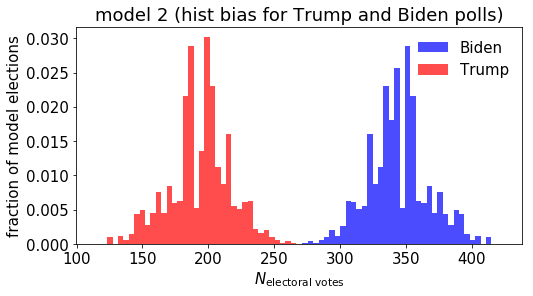

========== State-by-state vote predictions for model 2 (hist bias for Trump and Biden polls) ==========
               State   Biden win prob.  Trump win prob. 
             Arizona        0.683           0.317
             Florida        0.835           0.165
             Georgia        0.817           0.183
                Iowa        0.432           0.568
            Michigan        0.999           0.001
      North Carolina        0.593           0.407
              Nevada        0.999           0.001
                Ohio        0.217           0.783
        Pennsylvania        0.943           0.057
               Texas        0.172           0.828
           Wisconsin        0.988           0.012


In [19]:
plot_electoral_vote_distribution(model_name, model_results)
state_results(model_name, model_results, states, states_to_print=contested_states)

We can see that in this model the probability of Trump winning is still small. The model predicts probabilities of Biden wins for Florida, Georgia, Iowa, North Carolina that are still high. 

We can still examine the model in which bias is applied in different combinations. In some of these, like the one below, where I assume that bias for Trump is equal to historical, but bias for Biden is historical but with a minus sign, the probability of Trump winning is 82%!  This may not be realistic, but it alerts us that these biases are highly important and any systematic shift in these can have a dramatic effect on the model prediction. 

In [20]:
kwargs = {'dem_bias': -dem_bias, 'rep_bias': rep_bias}

model_results = simulate_elections(ppl, states, electors, date_range=date_range, poll_type=poll_type, 
                                    bias = True, min_weight = 0.01, nsims = nsims, **kwargs)

In [21]:
model_name = r'model 3 (hist bias for Trump polls, -bias for Biden polls)'
election_stats(model_name, model_results)

===============Results of election simulations in the  model 3 (hist bias for Trump polls, -bias for Biden polls) ===
Biden wins in 15.1450 per cent of elections
        average and median Nelectoral = 250.82 and 249.00; in 95 percent range = [219.00  292.00]
Trump   wins in 82.3760 per cent of elections
        average and median Nelectoral = 287.18 and 289.00; in 95 percent range = [246.00  319.00]
 2.4790 per cent of elections end up in electoral college draw


#### Bias approximating the actual outcome

There is a bias model that approximates the actual election outcome quite well, even without including correlations between states. As I showed in messages on Nov 4 in #hw04 channel, the poll bias for Trump in this election was fully consistent with the historical bias, while for Biden the polls in 2020 had almost no bias (this is also shown in plots included in the [12_election_regression notebook](https://drive.google.com/file/d/1yFnCBnM7xKKuy-FR8PyP55cXeB7nLAsx/view?usp=sharing). So pollsters were doing a much better job in this election in predicting the results, at least for one candidate. 

Once this is realized, you know that what you hear everywhere now about how pollsters got it wrong in 2016, and even more wrong in 2020 is rooted in complete lack of understanding of what is actually happening. 

At the same time, we can see that having even a relatively simple but *predictive* (and thus *falsifiable*) model for the process allows us to quickly identify what is occurring *and* the reason for it. 

So here are results for the model for which bias for Trump is assumed to be regular and comparable to historical results while for Biden the bias is assumed to be zero. 

In [22]:
date_range = ['2020-10-10', '2020-11-03']
nsims = 100000
poll_type = 'pct'

kwargs = {'dem_bias': np.zeros_like(dem_bias), 'rep_bias': rep_bias}

model_results = simulate_elections(ppl, states, electors, date_range=date_range, poll_type=poll_type, 
                                            hist_corr = False, correlations = False, bias = True,
                                            poll_permute = False, min_weight = 0.01, nsims = nsims, **kwargs)

In [23]:
model_name = r'model 4 (hist bias for Trump polls, no for Biden polls)'
election_stats(model_name, model_results)

===============Results of election simulations in the  model 4 (hist bias for Trump polls, no for Biden polls) ===
Biden wins in 89.7260 per cent of elections
        average and median Nelectoral = 297.89 and 296.00; in 95 percent range = [259.00  341.00]
Trump   wins in 8.5710 per cent of elections
        average and median Nelectoral = 240.11 and 242.00; in 95 percent range = [197.00  279.00]
 1.7030 per cent of elections end up in electoral college draw


In this case we see that Trump has $\approx 9\%$ probability of winning. Remarkably, there is now an almost $\approx 2%$ probability of electoral college draw! This definitely describes the actual outcome much more closely...

This model also has a more realistic distribution of probabilities for contested states, given the actual outcome of the election. There are still odd results like Arizona and Nevada, but overall the model describes the outcome pretty well, especially given how relatively simple it is.

We can actually improve upon this model in two ways: 1) include correlations between states (see below) and 2) improve our poll bias modelling, by taking into account correlation of the poll bias with the actual poll value (see exercise 3 in hw 5). The correlations are included in the simulations above and results for the model with the same bias as here, but including correlations is shown below. 

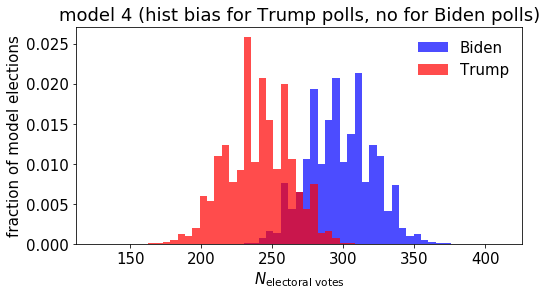

========== State-by-state vote predictions for model 4 (hist bias for Trump polls, no for Biden polls) ==========
               State   Biden win prob.  Trump win prob. 
             Arizona        0.223           0.777
             Florida        0.457           0.543
             Georgia        0.404           0.596
                Iowa        0.129           0.871
            Michigan        0.927           0.073
      North Carolina        0.275           0.725
              Nevada        0.971           0.029
                Ohio        0.067           0.933
        Pennsylvania        0.672           0.328
               Texas        0.016           0.984
           Wisconsin        0.921           0.079


In [24]:
plot_electoral_vote_distribution(model_name, model_results)
state_results(model_name, model_results, states, states_to_print=contested_states)

### Results of the model accounting for correlations between states. 

First, the function below computes covariance matrix and you can find more details of how this is done and how covariance is used to impose correlations upon random numbers drawn for different states in [state_poll_correlations](https://drive.google.com/file/d/1KiHjFcrVDc6sKuBZnfuXjriOXPbvJF-A/view?usp=sharing) notebook. 

In [25]:
# import covariance matrix estimation routine with regularization
from sklearn.covariance import oas

def compute_state_covariance_matrix(states, 
                                    url = 'http://astro.uchicago.edu/~andrey/classes/a205f20/data/presidential_polls_results.csv', 
                                    years = [2008, 2012, 2016]):
    """
    compute bias vectors and covariance matrix using 2008 and 2012 election results 
    """
    
    nstates     = len(states)
    prev_election_results = pandas.read_csv(url)
    
    nyrs = len(years)

    # initialize auxiliary arrays
    dem_results = np.zeros(nstates); rep_results = np.zeros(nstates)
    dem_polls = np.zeros((nyrs,nstates)); rep_polls = np.zeros((nyrs,nstates))
    dem_res = np.zeros((nyrs,nstates)); rep_res = np.zeros((nyrs,nstates))
    
    for i, yr in enumerate(years):
        # the lines below show you how to read and extract poll and election results of 
        # 3 previous Presidential elections
        dem_res[i,:] = np.array(prev_election_results['Dem_results_'+str(yr)])
        rep_res[i,:] = np.array(prev_election_results['Rep_results_'+str(yr)])
        dem_results += dem_res[i,:]
        rep_results += dem_res[i,:]
        
        dem_polls[i,:] = np.array(prev_election_results['Dem_polls_'+str(yr)])
        rep_polls[i,:] = np.array(prev_election_results['Rep_polls_'+str(yr)])
        
    dem_results = np.mean(dem_res, axis=0)
    rep_results = np.mean(rep_res, axis=0)
    dem_polls_ave = np.mean(dem_polls, axis=0)
    rep_polls_ave = np.mean(rep_polls, axis=0)
    
    bias_dem = dem_results - dem_polls_ave
    bias_rep = rep_results - rep_polls_ave
    bdem_var = np.var(dem_res-dem_polls, ddof=1, axis=0)
    brep_var = np.var(rep_res-rep_polls, ddof=1, axis=0)
    
    # regularize empirical covariance matrix estimate
    cov_dem, shr_dem = oas(dem_res-dem_polls)
    cov_rep, shr_rep = oas(rep_res-rep_polls)
    corr_dem, corr_rep = np.zeros_like(cov_dem), np.zeros_like(cov_dem)
    for i in range(nstates):
        for j in range(nstates):
            corr_dem[i,j] = cov_dem[i,j] / np.sqrt(cov_dem[i,i] * cov_dem[j,j])
            corr_rep[i,j] = cov_rep[i,j] / np.sqrt(cov_rep[i,i] * cov_rep[j,j])
    
        
    return bias_dem, cov_dem, bdem_var, bias_rep, cov_rep, brep_var

In [26]:
dem_bias, cov_dem, bdem_var, rep_bias, cov_rep, brep_var = compute_state_covariance_matrix(states)

# check that covariance matrices are positive-definite by trying their Cholesky decomposition 
ltest = np.linalg.cholesky(cov_dem)
ltest = np.linalg.cholesky(cov_rep)

In [27]:
# code to plot downloaded image
from matplotlib.colors import LogNorm

def plot_image(img, figsize = (8,8)):
    plt.figure(figsize = figsize)
    # imshow method of pylab displays 2d array of float values as a pixelated image
    plt.imshow(img, cmap=plt.cm.RdBu_r) # LogNorm stretches color map so bg is visible
    # color bar will show how flux values correspond to displayed gray color
    plt.colorbar(fraction = 0.046, pad = 0.04) # input parameters chosen so color bar fits plot
    plt.show()


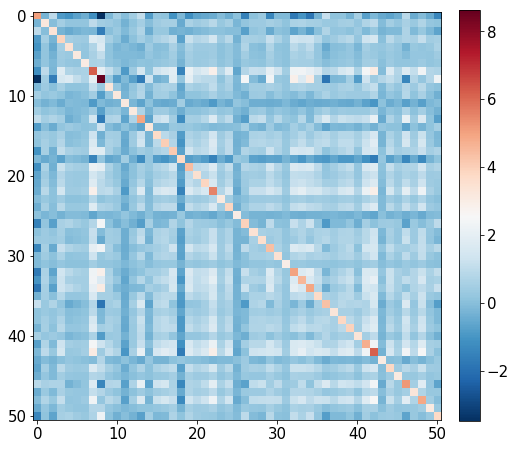

In [28]:
# this is how the covariance matrix looks like
# not particularly meaningful, but it does give as an idea about magnitude of correlations (color bar in percent^2)
plot_image(cov_dem)

In [29]:
date_range = ['2020-10-15', '2020-11-03']
nsims = 100000
poll_type = 'pct'
kwargs = {'cov_dem': cov_dem, 'cov_rep': cov_rep, 
          'dem_bias': np.zeros_like(dem_bias), 'rep_bias': rep_bias}

model_results = simulate_elections(ppl, states=states, electors=electors, date_range=date_range, poll_type=poll_type, 
                                   correlations = True, bias = True, min_weight = 0.01, nsims = nsims, **kwargs)

In [30]:
model_name = r'model 5 (including correlations, zero bias Biden, regular bias Trump)'
election_stats(model_name, model_results)

===============Results of election simulations in the  model 5 (including correlations, zero bias Biden, regular bias Trump) ===
Biden wins in 83.6580 per cent of elections
        average and median Nelectoral = 297.10 and 295.00; in 95 percent range = [243.00  350.00]
Trump   wins in 14.7700 per cent of elections
        average and median Nelectoral = 240.90 and 243.00; in 95 percent range = [188.00  295.00]
 1.5720 per cent of elections end up in electoral college draw


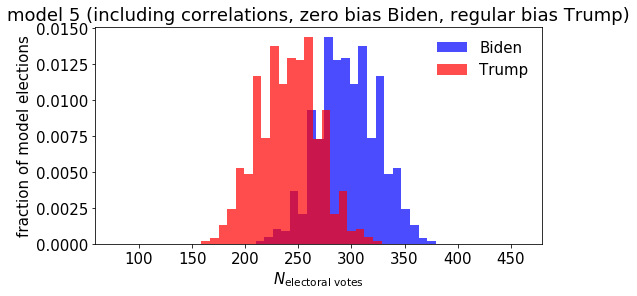

========== State-by-state vote predictions for model 5 (including correlations, zero bias Biden, regular bias Trump) ==========
               State   Biden win prob.  Trump win prob. 
             Arizona        0.269           0.731
             Florida        0.454           0.546
             Georgia        0.371           0.629
                Iowa        0.108           0.892
            Michigan        0.921           0.079
      North Carolina        0.307           0.693
              Nevada        0.948           0.052
                Ohio        0.071           0.929
        Pennsylvania        0.629           0.371
               Texas        0.020           0.980
           Wisconsin        0.914           0.086


In [31]:
plot_electoral_vote_distribution(model_name, model_results)
state_results(model_name, model_results, states, states_to_print=contested_states)

We can see that correlations do not change results of the model without them somewhat and increases probability of Trump win to $14\%$. The peaks in the predicted electoral count distribution look close to where things seem to be heading. Nevertheless, the results are not qualitatively different from the model without correlations. 

In particular, results for Nevada and Arizona still look suspicious. For completeness, here is a plot of the electoral votes vs popular vote. This plot also looks closer to the actual outcome. 

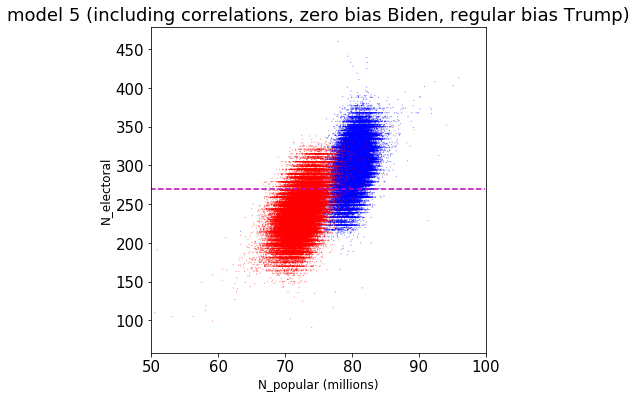

In [32]:
plot_nelectoral_vs_popular_vote(model_name, model_results, states, electors, state_pop)

Results of this model can be improved by calibrating historical bias correlation with the poll value and accounting for scatter around this correlation (optional exercise 3 of hw 5). 

## Summary

I showed this quote on Monday from the 18th century German astronomer F.W. Argelander:

<center>
 <font color='darkblue'>"But happily, hypotheses, even if full of error, fail us not."</font>
<br>
    
and we discussed its meaning. The results of the exercises that we did provide a good illustration of this. 

Despite the fact that the simple model based on the assumptions that polls are correct failed to describe the actual election outcome, tsing a simple, but predictive (and thus falsifiable) model for an experiment, allowed us to quickly interpret the results of the experiment and understand the reason for why the outcome turned out be the way it did. 
    
***So indeed our model "failed us not"!***